# Análise de Regressão - Predição de Dias de Atraso

Este notebook implementa um modelo de regressão para prever o número de dias de atraso nos pagamentos, baseado na análise de dados históricos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Carregamento e Exploração dos Dados

In [2]:
# Carregamento dos dados
data_folder = './data'
files = [
    'base_cadastral.csv',
    'base_info.csv',
    'base_pagamentos_desenvolvimento.csv',
    'base_pagamentos_teste.csv'
]

dfs = {}
for file in files:
    path = os.path.join(data_folder, file)
    try:
        dfs[file] = pd.read_csv(path, sep=';')
        print(f'Loaded {file} with shape {dfs[file].shape}')
    except Exception as e:
        print(f'Error loading {file}: {e}')

# Criando variáveis para facilitar o acesso
df_cadastral = dfs['base_cadastral.csv']
df_info = dfs['base_info.csv']
df_dev = dfs['base_pagamentos_desenvolvimento.csv']
df_teste = dfs['base_pagamentos_teste.csv']

Loaded base_cadastral.csv with shape (1315, 8)
Loaded base_info.csv with shape (24401, 4)
Loaded base_pagamentos_desenvolvimento.csv with shape (77414, 7)
Loaded base_pagamentos_teste.csv with shape (12275, 6)


## 2. Análise Exploratória das Bases

In [3]:
print("=== BASE CADASTRAL ===")
print(f"Shape: {df_cadastral.shape}")
print("\nPrimeiras linhas:")
display(df_cadastral.head())
print("\nInformações dos dados:")
print(df_cadastral.info())
print("\nEstatísticas descritivas:")
display(df_cadastral.describe())

=== BASE CADASTRAL ===
Shape: (1315, 8)

Primeiras linhas:


,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
1,8274986328479596038,2017-01-25,31,NaN,Comércio,YAHOO,MEDIO,77
2,345447888460137901,2000-08-15,75,NaN,Serviços,HOTMAIL,PEQUENO,48
3,1003144834589372198,2017-08-06,49,NaN,Serviços,OUTLOOK,PEQUENO,89
4,324916756972236008,2011-02-14,88,NaN,Serviços,GMAIL,GRANDE,62



Informações dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_CLIENTE           1315 non-null   int64 
 1   DATA_CADASTRO        1315 non-null   object
 2   DDD                  1078 non-null   object
 3   FLAG_PF              66 non-null     object
 4   SEGMENTO_INDUSTRIAL  1232 non-null   object
 5   DOMINIO_EMAIL        1285 non-null   object
 6   PORTE                1274 non-null   object
 7   CEP_2_DIG            1315 non-null   object
dtypes: int64(1), object(7)
memory usage: 82.3+ KB
None

Estatísticas descritivas:


,ID_CLIENTE
count,1.315000e+03
mean,4.637945e+18
std,2.667894e+18
min,8.784237e+15
25%,2.307709e+18
50%,4.714188e+18
75%,6.973809e+18
max,9.206031e+18


In [4]:
print("=== BASE PAGAMENTOS DESENVOLVIMENTO ===")
print(f"Shape: {df_dev.shape}")
print("\nPrimeiras linhas:")
display(df_dev.head())
print("\nInformações dos dados:")
print(df_dev.info())
print("\nEstatísticas descritivas:")
display(df_dev.describe())

=== BASE PAGAMENTOS DESENVOLVIMENTO ===
Shape: (77414, 7)

Primeiras linhas:


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99



Informações dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77414 entries, 0 to 77413
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_CLIENTE              77414 non-null  int64  
 1   SAFRA_REF               77414 non-null  object 
 2   DATA_EMISSAO_DOCUMENTO  77414 non-null  object 
 3   DATA_PAGAMENTO          77414 non-null  object 
 4   DATA_VENCIMENTO         77414 non-null  object 
 5   VALOR_A_PAGAR           76244 non-null  float64
 6   TAXA                    77414 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 4.1+ MB
None

Estatísticas descritivas:


,ID_CLIENTE,VALOR_A_PAGAR,TAXA
count,7.741400e+04,7.624400e+04,77414.000000
mean,4.662270e+18,4.659078e+04,6.789623
std,2.665719e+18,4.643393e+04,1.798225
min,8.784237e+15,1.000000e-01,4.990000
25%,2.369365e+18,1.876536e+04,5.990000
50%,4.817817e+18,3.475869e+04,5.990000
75%,6.969349e+18,6.093384e+04,6.990000
max,9.206031e+18,4.400000e+06,11.990000


In [5]:
print("=== BASE INFO ===")
print(f"Shape: {df_info.shape}")
print("\nPrimeiras linhas:")
display(df_info.head())
print("\nInformações dos dados:")
print(df_info.info())
print("\nEstatísticas descritivas:")
display(df_info.describe())

=== BASE INFO ===
Shape: (24401, 4)

Primeiras linhas:


,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-09,16913.0,NaN
1,8274986328479596038,2018-09,106430.0,141.0
2,345447888460137901,2018-09,707439.0,99.0
3,1003144834589372198,2018-09,239659.0,96.0
4,324916756972236008,2018-09,203123.0,103.0



Informações dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24401 entries, 0 to 24400
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_CLIENTE          24401 non-null  int64  
 1   SAFRA_REF           24401 non-null  object 
 2   RENDA_MES_ANTERIOR  23684 non-null  float64
 3   NO_FUNCIONARIOS     23149 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 762.7+ KB
None

Estatísticas descritivas:


,ID_CLIENTE,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
count,2.440100e+04,2.368400e+04,23149.000000
mean,4.668214e+18,2.887514e+05,117.799646
std,2.669294e+18,2.115948e+05,21.464574
min,8.784237e+15,1.050000e+02,0.000000
25%,2.347029e+18,1.338662e+05,106.000000
50%,4.795153e+18,2.409985e+05,118.000000
75%,7.061869e+18,3.925018e+05,131.000000
max,9.206031e+18,1.682759e+06,198.000000


In [6]:
print("=== BASE PAGAMENTOS TESTE ===")
print(f"Shape: {df_teste.shape}")
print("\nPrimeiras linhas:")
display(df_teste.head())
print("\nInformações dos dados:")
print(df_teste.info())
print("\nEstatísticas descritivas:")
display(df_teste.describe())

=== BASE PAGAMENTOS TESTE ===
Shape: (12275, 6)

Primeiras linhas:


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99



Informações dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12275 entries, 0 to 12274
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_CLIENTE              12275 non-null  int64  
 1   SAFRA_REF               12275 non-null  object 
 2   DATA_EMISSAO_DOCUMENTO  12275 non-null  object 
 3   DATA_VENCIMENTO         12275 non-null  object 
 4   VALOR_A_PAGAR           12144 non-null  float64
 5   TAXA                    12275 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 575.5+ KB
None

Estatísticas descritivas:


,ID_CLIENTE,VALOR_A_PAGAR,TAXA
count,1.227500e+04,12144.000000,12275.000000
mean,4.670820e+18,65883.258575,6.807271
std,2.667868e+18,55919.404970,1.835351
min,8.784237e+15,6.900000,4.990000
25%,2.308217e+18,26712.335000,5.990000
50%,4.850936e+18,49665.210000,5.990000
75%,6.964109e+18,87029.362500,6.990000
max,9.206031e+18,830000.000000,11.990000


## 3. Criação da Variável Target (Dias de Atraso)

In [7]:
# Convertendo colunas de data para datetime
df_dev['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_dev['DATA_EMISSAO_DOCUMENTO'])
df_dev['DATA_PAGAMENTO'] = pd.to_datetime(df_dev['DATA_PAGAMENTO'])
df_dev['DATA_VENCIMENTO'] = pd.to_datetime(df_dev['DATA_VENCIMENTO'])

# Calculando dias de atraso (VARIÁVEL TARGET)
df_dev['DIAS_ATRASO'] = (df_dev['DATA_PAGAMENTO'] - df_dev['DATA_VENCIMENTO']).dt.days

# Criando categoria de inadimplência para análise (1 = inadimplente, 0 = adimplente)
df_dev['INADIMPLENTE'] = (df_dev['DIAS_ATRASO'] >= 5).astype(int)

print("Distribuição da categoria de inadimplência:")
print(df_dev['INADIMPLENTE'].value_counts())
print(f"\nTaxa de inadimplência: {df_dev['INADIMPLENTE'].mean():.2%}")

print("\nEstatísticas dos dias de atraso (variável target):")
print(df_dev['DIAS_ATRASO'].describe())

print("\nAnálise da distribuição dos dias de atraso:")
print(f"Pagamentos em dia (≤ 0 dias): {(df_dev['DIAS_ATRASO'] <= 0).sum():,} ({(df_dev['DIAS_ATRASO'] <= 0).mean():.1%})")
print(f"Pagamentos com 1-4 dias de atraso: {((df_dev['DIAS_ATRASO'] > 0) & (df_dev['DIAS_ATRASO'] < 5)).sum():,} ({((df_dev['DIAS_ATRASO'] > 0) & (df_dev['DIAS_ATRASO'] < 5)).mean():.1%})")
print(f"Pagamentos com 5+ dias de atraso: {(df_dev['DIAS_ATRASO'] >= 5).sum():,} ({(df_dev['DIAS_ATRASO'] >= 5).mean():.1%})")

Distribuição da categoria de inadimplência:
INADIMPLENTE
0    71978
1     5436
Name: count, dtype: int64

Taxa de inadimplência: 7.02%

Estatísticas dos dias de atraso (variável target):
count    77414.000000
mean        -0.171429
std         25.229477
min      -2661.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        869.000000
Name: DIAS_ATRASO, dtype: float64

Análise da distribuição dos dias de atraso:
Pagamentos em dia (≤ 0 dias): 68,648 (88.7%)
Pagamentos com 1-4 dias de atraso: 3,330 (4.3%)
Pagamentos com 5+ dias de atraso: 5,436 (7.0%)


## 4. Engenharia de Features

In [8]:
# Features temporais
df_dev['MES_PAGAMENTO'] = df_dev['DATA_PAGAMENTO'].dt.month
df_dev['ANO_PAGAMENTO'] = df_dev['DATA_PAGAMENTO'].dt.year
df_dev['DIA_SEMANA_PAGAMENTO'] = df_dev['DATA_PAGAMENTO'].dt.dayofweek

# Features de valor
df_dev['VALOR_CATEGORIA'] = pd.cut(df_dev['VALOR_A_PAGAR'], 
                                   bins=[0, 1000, 5000, 10000, float('inf')], 
                                   labels=['Baixo', 'Médio', 'Alto', 'Muito Alto'])

# Features de taxa
df_dev['TAXA_CATEGORIA'] = pd.cut(df_dev['TAXA'], 
                                  bins=[0, 0.05, 0.10, 0.15, float('inf')], 
                                  labels=['Baixa', 'Média', 'Alta', 'Muito Alta'])

print("Features criadas com sucesso!")
print(f"Shape final: {df_dev.shape}")

Features criadas com sucesso!
Shape final: (77414, 14)


In [9]:
# Merge com dados cadastrais
df_merged = df_dev.merge(df_cadastral, on='ID_CLIENTE', how='left')

# Merge com dados de informação mensal
df_merged = df_merged.merge(df_info, on=['ID_CLIENTE', 'SAFRA_REF'], how='left')

print(f"Shape após merge: {df_merged.shape}")
print(f"Colunas disponíveis: {list(df_merged.columns)}")

# Verificando missing values após merge
print("\nMissing values após merge:")
missing_data = df_merged.isnull().sum()
print(missing_data[missing_data > 0])

Shape após merge: (77414, 23)
Colunas disponíveis: ['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO', 'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA', 'DIAS_ATRASO', 'INADIMPLENTE', 'MES_PAGAMENTO', 'ANO_PAGAMENTO', 'DIA_SEMANA_PAGAMENTO', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA', 'DATA_CADASTRO', 'DDD', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']

Missing values após merge:
VALOR_A_PAGAR           1170
VALOR_CATEGORIA         1170
DDD                     7414
FLAG_PF                77195
SEGMENTO_INDUSTRIAL     1417
DOMINIO_EMAIL            898
PORTE                   2476
RENDA_MES_ANTERIOR      6132
NO_FUNCIONARIOS         7587
dtype: int64


## 5. Análise de Correlação e Distribuição

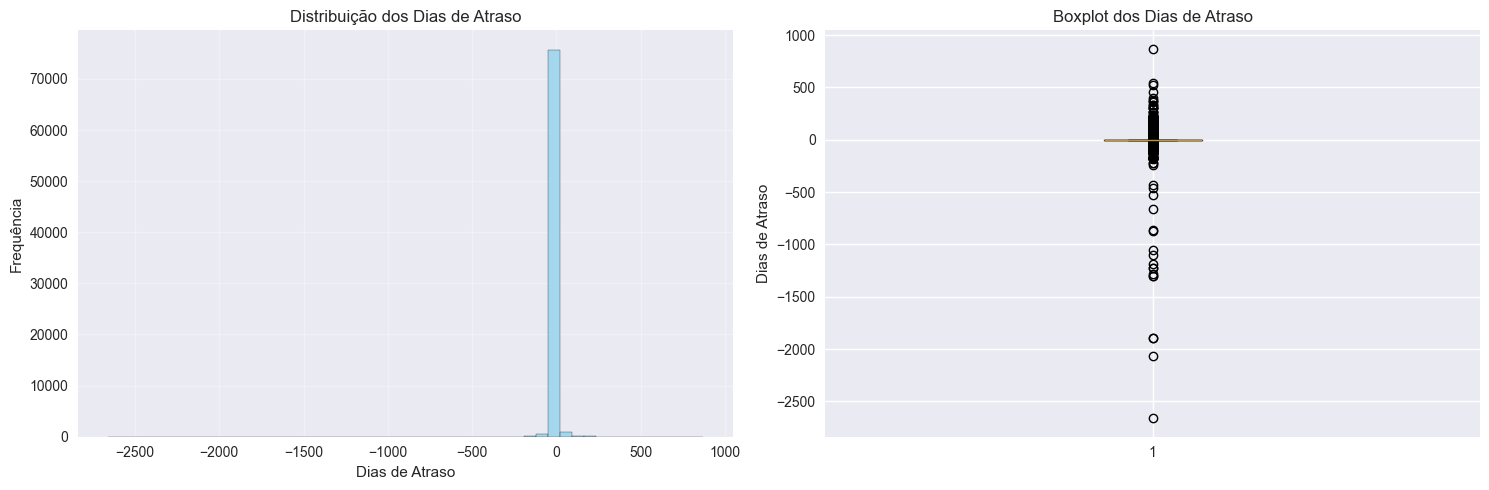

In [10]:
# Análise da distribuição da variável target
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma dos dias de atraso
axes[0].hist(df_merged['DIAS_ATRASO'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Distribuição dos Dias de Atraso')
axes[0].set_xlabel('Dias de Atraso')
axes[0].set_ylabel('Frequência')
axes[0].grid(True, alpha=0.3)

# Boxplot dos dias de atraso
axes[1].boxplot(df_merged['DIAS_ATRASO'])
axes[1].set_title('Boxplot dos Dias de Atraso')
axes[1].set_ylabel('Dias de Atraso')

plt.tight_layout()
plt.show()

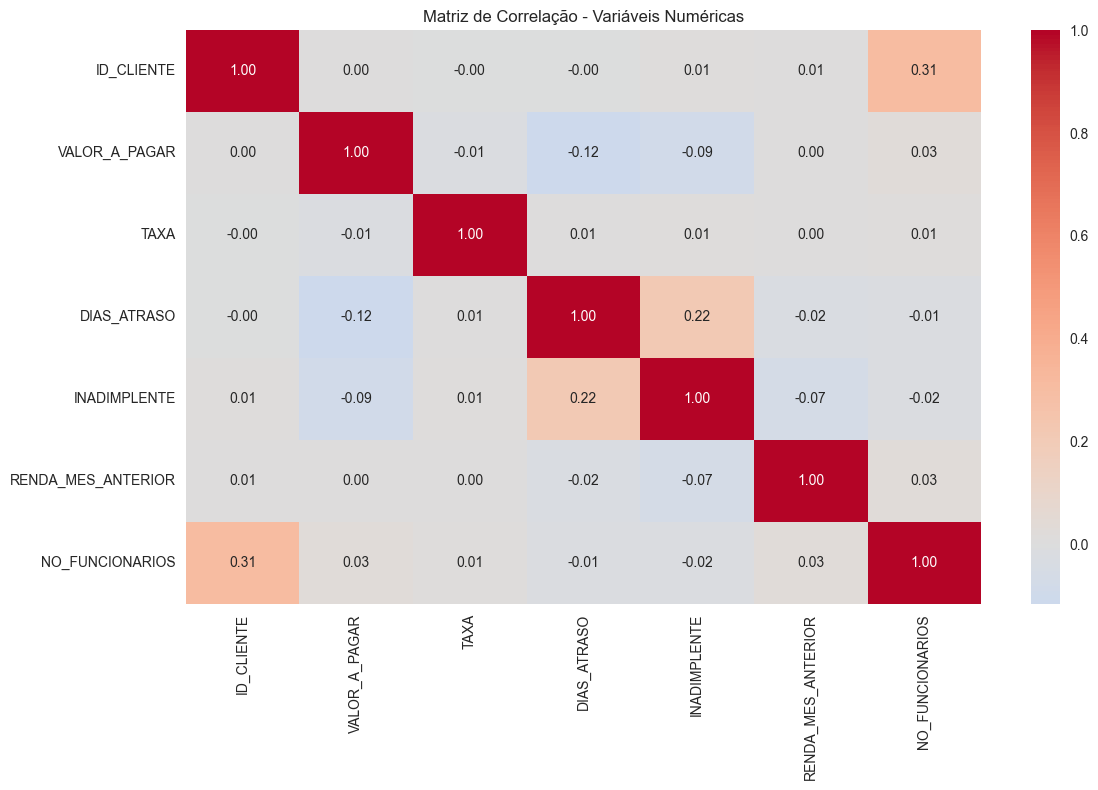

In [11]:
# Análise de correlação entre variáveis numéricas
numeric_columns = df_merged.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_merged[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlação - Variáveis Numéricas')
plt.tight_layout()
plt.show()

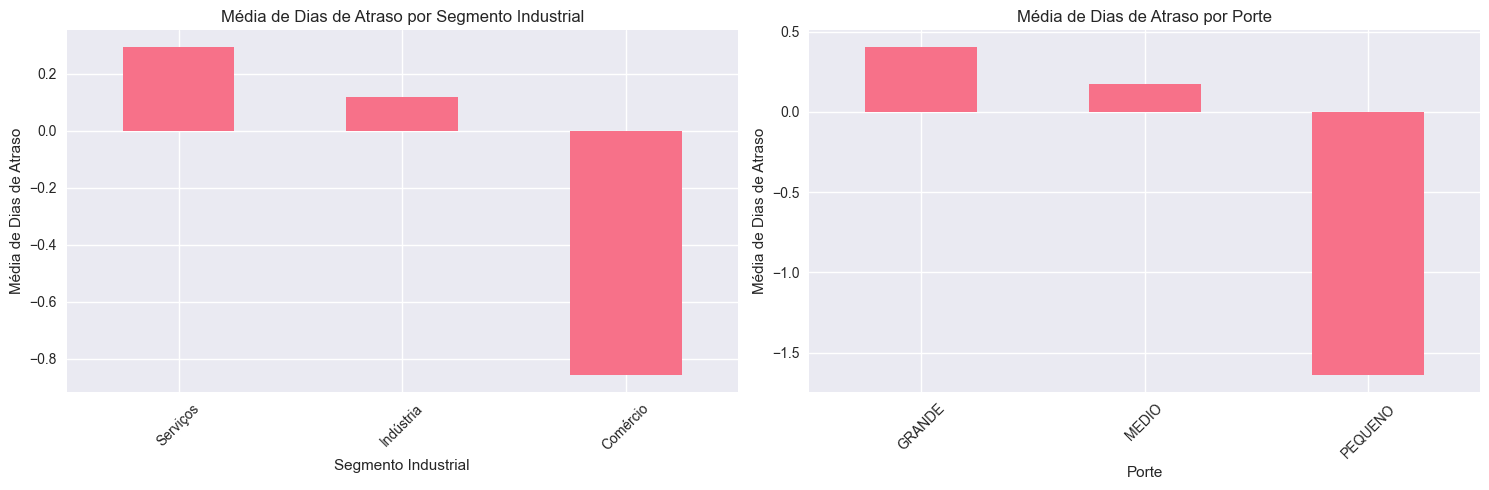

In [12]:
# Análise dos dias de atraso por segmento industrial
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Média de dias de atraso por segmento
segmento_atraso = df_merged.groupby('SEGMENTO_INDUSTRIAL')['DIAS_ATRASO'].mean().sort_values(ascending=False)
segmento_atraso.plot(kind='bar', ax=axes[0])
axes[0].set_title('Média de Dias de Atraso por Segmento Industrial')
axes[0].set_xlabel('Segmento Industrial')
axes[0].set_ylabel('Média de Dias de Atraso')
axes[0].tick_params(axis='x', rotation=45)

# Média de dias de atraso por porte
porte_atraso = df_merged.groupby('PORTE')['DIAS_ATRASO'].mean().sort_values(ascending=False)
porte_atraso.plot(kind='bar', ax=axes[1])
axes[1].set_title('Média de Dias de Atraso por Porte')
axes[1].set_xlabel('Porte')
axes[1].set_ylabel('Média de Dias de Atraso')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Preparação dos Dados para Machine Learning

In [13]:
# Selecionando features para o modelo (DIAS_ATRASO como target)
features_numericas = ['VALOR_A_PAGAR', 'TAXA', 'MES_PAGAMENTO', 'ANO_PAGAMENTO', 'DIA_SEMANA_PAGAMENTO']
features_categoricas = ['SEGMENTO_INDUSTRIAL', 'PORTE', 'DOMINIO_EMAIL', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA']

# Adicionando features de informação mensal se disponíveis
if 'RENDA_MES_ANTERIOR' in df_merged.columns:
    features_numericas.append('RENDA_MES_ANTERIOR')
if 'NO_FUNCIONARIOS' in df_merged.columns:
    features_numericas.append('NO_FUNCIONARIOS')

# Criando dataset para modelagem (DIAS_ATRASO como target)
df_model = df_merged[features_numericas + features_categoricas + ['DIAS_ATRASO']].copy()

print(f"Shape do dataset para modelagem: {df_model.shape}")
print(f"Features numéricas: {features_numericas}")
print(f"Features categóricas: {features_categoricas}")
print(f"Variável target: DIAS_ATRASO")

Shape do dataset para modelagem: (77414, 13)
Features numéricas: ['VALOR_A_PAGAR', 'TAXA', 'MES_PAGAMENTO', 'ANO_PAGAMENTO', 'DIA_SEMANA_PAGAMENTO', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']
Features categóricas: ['SEGMENTO_INDUSTRIAL', 'PORTE', 'DOMINIO_EMAIL', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA']
Variável target: DIAS_ATRASO


In [14]:
# Tratamento de missing values
print("Missing values antes do tratamento:")
print(df_model.isnull().sum())

# Para variáveis numéricas: imputação com mediana
imputer_numerico = SimpleImputer(strategy='median')
df_model[features_numericas] = imputer_numerico.fit_transform(df_model[features_numericas])

# Para variáveis categóricas: imputação com moda
imputer_categorico = SimpleImputer(strategy='most_frequent')
df_model[features_categoricas] = imputer_categorico.fit_transform(df_model[features_categoricas])

print("\nMissing values após o tratamento:")
print(df_model.isnull().sum())

Missing values antes do tratamento:
VALOR_A_PAGAR           1170
TAXA                       0
MES_PAGAMENTO              0
ANO_PAGAMENTO              0
DIA_SEMANA_PAGAMENTO       0
RENDA_MES_ANTERIOR      6132
NO_FUNCIONARIOS         7587
SEGMENTO_INDUSTRIAL     1417
PORTE                   2476
DOMINIO_EMAIL            898
VALOR_CATEGORIA         1170
TAXA_CATEGORIA             0
DIAS_ATRASO                0
dtype: int64

Missing values após o tratamento:
VALOR_A_PAGAR           0
TAXA                    0
MES_PAGAMENTO           0
ANO_PAGAMENTO           0
DIA_SEMANA_PAGAMENTO    0
RENDA_MES_ANTERIOR      0
NO_FUNCIONARIOS         0
SEGMENTO_INDUSTRIAL     0
PORTE                   0
DOMINIO_EMAIL           0
VALOR_CATEGORIA         0
TAXA_CATEGORIA          0
DIAS_ATRASO             0
dtype: int64


In [15]:
# Encoding de variáveis categóricas
label_encoders = {}
for col in features_categoricas:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

# Criando lista final de features
features_finais = features_numericas + [col + '_encoded' for col in features_categoricas]

print(f"Features finais para o modelo: {features_finais}")
print(f"Total de features: {len(features_finais)}")

Features finais para o modelo: ['VALOR_A_PAGAR', 'TAXA', 'MES_PAGAMENTO', 'ANO_PAGAMENTO', 'DIA_SEMANA_PAGAMENTO', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'SEGMENTO_INDUSTRIAL_encoded', 'PORTE_encoded', 'DOMINIO_EMAIL_encoded', 'VALOR_CATEGORIA_encoded', 'TAXA_CATEGORIA_encoded']
Total de features: 12


## 7. Criação e Avaliação dos Modelos

In [16]:
# Preparando dados (DIAS_ATRASO como target)
X = df_model[features_finais]
y = df_model['DIAS_ATRASO']

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape dos dados de treino: {X_train.shape}")
print(f"Shape dos dados de teste: {X_test.shape}")
print(f"Média de dias de atraso no treino: {y_train.mean():.2f} dias")
print(f"Média de dias de atraso no teste: {y_test.mean():.2f} dias")
print(f"Desvio padrão dos dias de atraso no treino: {y_train.std():.2f} dias")
print(f"Desvio padrão dos dias de atraso no teste: {y_test.std():.2f} dias")

Shape dos dados de treino: (61931, 12)
Shape dos dados de teste: (15483, 12)
Média de dias de atraso no treino: -0.16 dias
Média de dias de atraso no teste: -0.21 dias
Desvio padrão dos dias de atraso no treino: 24.25 dias
Desvio padrão dos dias de atraso no teste: 28.82 dias


In [17]:
# Modelo Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predições
y_pred_rf = rf_model.predict(X_test)

# Avaliação
print("=== RANDOM FOREST REGRESSOR ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"R²: {r2_score(y_test, y_pred_rf):.3f}")

=== RANDOM FOREST REGRESSOR ===
RMSE: 28.68
MAE: 3.30
R²: 0.009


In [18]:
# Modelo Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predições
y_pred_lr = lr_model.predict(X_test)

# Avaliação
print("=== LINEAR REGRESSION ===")
print(f"RMSE: {mean_squared_error(y_test, y_pred_lr, squared=False):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f"R²: {r2_score(y_test, y_pred_lr):.3f}")

=== LINEAR REGRESSION ===


TypeError: got an unexpected keyword argument 'squared'

In [ ]:
# Comparação dos modelos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de dispersão - Random Forest
axes[0].scatter(y_test, y_pred_rf, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Valor Real')
axes[0].set_ylabel('Valor Predito')
axes[0].set_title('Random Forest: Real vs Predito')
axes[0].grid(True, alpha=0.3)

# Gráfico de dispersão - Linear Regression
axes[1].scatter(y_test, y_pred_lr, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valor Real')
axes[1].set_ylabel('Valor Predito')
axes[1].set_title('Linear Regression: Real vs Predito')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Análise de Importância das Features

In [ ]:
# Importância das features (Random Forest)
feature_importance = pd.DataFrame({
    'feature': features_finais,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Features Mais Importantes - Random Forest')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

print("Top 10 features mais importantes:")
print(feature_importance.head(10))

## 9. Preparação dos Dados de Teste para Predição

In [ ]:
# Preparando dados de teste para predição
df_teste_processed = df_teste.copy()

# Convertendo datas
df_teste_processed['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_teste_processed['DATA_EMISSAO_DOCUMENTO'])
df_teste_processed['DATA_VENCIMENTO'] = pd.to_datetime(df_teste_processed['DATA_VENCIMENTO'])

# Criando features temporais
df_teste_processed['MES_VENCIMENTO'] = df_teste_processed['DATA_VENCIMENTO'].dt.month
df_teste_processed['ANO_VENCIMENTO'] = df_teste_processed['DATA_VENCIMENTO'].dt.year
df_teste_processed['DIA_SEMANA_VENCIMENTO'] = df_teste_processed['DATA_VENCIMENTO'].dt.dayofweek

# Features de valor e taxa
df_teste_processed['VALOR_CATEGORIA'] = pd.cut(df_teste_processed['VALOR_A_PAGAR'], 
                                               bins=[0, 1000, 5000, 10000, float('inf')], 
                                               labels=['Baixo', 'Médio', 'Alto', 'Muito Alto'])
df_teste_processed['TAXA_CATEGORIA'] = pd.cut(df_teste_processed['TAXA'], 
                                              bins=[0, 0.05, 0.10, 0.15, float('inf')], 
                                              labels=['Baixa', 'Média', 'Alta', 'Muito Alta'])

print("Dados de teste processados com sucesso!")
print(f"Shape: {df_teste_processed.shape}")

In [ ]:
# Merge com dados cadastrais e info
df_teste_final = df_teste_processed.merge(df_cadastral, on='ID_CLIENTE', how='left')
df_teste_final = df_teste_final.merge(df_info, on=['ID_CLIENTE', 'SAFRA_REF'], how='left')

# Selecionando features para predição
features_teste = ['VALOR_A_PAGAR', 'TAXA', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO',
                  'SEGMENTO_INDUSTRIAL', 'PORTE', 'DOMINIO_EMAIL', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA']

# Adicionando features de informação mensal se disponíveis
if 'RENDA_MES_ANTERIOR' in df_teste_final.columns:
    features_teste.append('RENDA_MES_ANTERIOR')
if 'NO_FUNCIONARIOS' in df_teste_final.columns:
    features_teste.append('NO_FUNCIONARIOS')

print(f"Features para predição: {features_teste}")
print(f"Shape final dos dados de teste: {df_teste_final.shape}")

## 10. Predições nos Dados de Teste

In [ ]:
# Preparando dados de teste para predição
df_teste_model = df_teste_final[features_teste].copy()

# Tratamento de missing values
imputer_numerico_teste = SimpleImputer(strategy='median')
imputer_categorico_teste = SimpleImputer(strategy='most_frequent')

# Separando features numéricas e categóricas
features_numericas_teste = ['VALOR_A_PAGAR', 'TAXA', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO']
features_categoricas_teste = ['SEGMENTO_INDUSTRIAL', 'PORTE', 'DOMINIO_EMAIL', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA']

# Adicionando features de informação mensal se disponíveis
if 'RENDA_MES_ANTERIOR' in df_teste_model.columns:
    features_numericas_teste.append('RENDA_MES_ANTERIOR')
if 'NO_FUNCIONARIOS' in df_teste_model.columns:
    features_numericas_teste.append('NO_FUNCIONARIOS')

# Aplicando imputação
df_teste_model[features_numericas_teste] = imputer_numerico_teste.fit_transform(df_teste_model[features_numericas_teste])
df_teste_model[features_categoricas_teste] = imputer_categorico_teste.fit_transform(df_teste_model[features_categoricas_teste])

# Encoding de variáveis categóricas
for col in features_categoricas_teste:
    if col in label_encoders:
        df_teste_model[col + '_encoded'] = label_encoders[col].transform(df_teste_model[col].astype(str))
    else:
        # Se não temos o encoder, criamos um novo
        le = LabelEncoder()
        df_teste_model[col + '_encoded'] = le.fit_transform(df_teste_model[col].astype(str))

# Criando lista final de features para teste
features_finais_teste = features_numericas_teste + [col + '_encoded' for col in features_categoricas_teste]

print(f"Features finais para teste: {features_finais_teste}")
print(f"Shape dos dados de teste processados: {df_teste_model.shape}")

In [ ]:
# Fazendo predições com o melhor modelo (Random Forest Regressor)
X_teste = df_teste_model[features_finais_teste]

# Predições de dias de atraso
dias_atraso_previsto = rf_model.predict(X_teste)

# Adicionando predições ao dataset original
df_resultado_final = df_teste.copy()
df_resultado_final['DIAS_ATRASO_PREVISTO'] = dias_atraso_previsto

print("Predições realizadas com sucesso!")
print(f"Shape do resultado: {df_resultado_final.shape}")
print("\nEstatísticas dos dias de atraso previstos:")
print(df_resultado_final['DIAS_ATRASO_PREVISTO'].describe())

# Mostrando primeiros resultados
print("\nPrimeiros 10 registros com predições:")
display(df_resultado_final[['ID_CLIENTE', 'SAFRA_REF', 'VALOR_A_PAGAR', 'TAXA', 'DIAS_ATRASO_PREVISTO']].head(10))

In [ ]:
# Análise dos resultados
print("=== ANÁLISE DOS RESULTADOS ===")
print(f"Média de dias de atraso previstos: {df_resultado_final['DIAS_ATRASO_PREVISTO'].mean():.2f} dias")
print(f"Mediana de dias de atraso previstos: {df_resultado_final['DIAS_ATRASO_PREVISTO'].median():.2f} dias")
print(f"Desvio padrão dos dias de atraso previstos: {df_resultado_final['DIAS_ATRASO_PREVISTO'].std():.2f} dias")

# Análise da distribuição das predições
print("\nDistribuição das predições:")
print(f"Predições ≤ 0 dias (em dia): {(df_resultado_final['DIAS_ATRASO_PREVISTO'] <= 0).sum():,} ({(df_resultado_final['DIAS_ATRASO_PREVISTO'] <= 0).mean():.1%})")
print(f"Predições 1-4 dias de atraso: {((df_resultado_final['DIAS_ATRASO_PREVISTO'] > 0) & (df_resultado_final['DIAS_ATRASO_PREVISTO'] < 5)).sum():,} ({((df_resultado_final['DIAS_ATRASO_PREVISTO'] > 0) & (df_resultado_final['DIAS_ATRASO_PREVISTO'] < 5)).mean():.1%})")
print(f"Predições ≥ 5 dias de atraso: {(df_resultado_final['DIAS_ATRASO_PREVISTO'] >= 5).sum():,} ({(df_resultado_final['DIAS_ATRASO_PREVISTO'] >= 5).mean():.1%})")

# Histograma das predições
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_resultado_final['DIAS_ATRASO_PREVISTO'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Dias de Atraso Previstos')
plt.xlabel('Dias de Atraso Previstos')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(df_resultado_final['DIAS_ATRASO_PREVISTO'])
plt.title('Boxplot dos Dias de Atraso Previstos')
plt.ylabel('Dias de Atraso Previstos')

plt.tight_layout()
plt.show()

In [ ]:
# Salvando resultados
df_resultado_final.to_csv('./data/resultados_regressao_dias_atraso.csv', index=False, sep=';')
print("Resultados salvos em './data/resultados_regressao_dias_atraso.csv'")

# Resumo final
print("\n=== RESUMO FINAL ===")
print(f"Total de registros analisados: {len(df_resultado_final):,}")
print(f"Média de dias de atraso previstos: {df_resultado_final['DIAS_ATRASO_PREVISTO'].mean():.2f} dias")
print(f"Registros com predição de inadimplência (≥5 dias): {len(df_resultado_final[df_resultado_final['DIAS_ATRASO_PREVISTO'] >= 5]):,}")
print(f"Registros com predição de pagamento em dia (≤0 dias): {len(df_resultado_final[df_resultado_final['DIAS_ATRASO_PREVISTO'] <= 0]):,}")

print("\nModelo de Regressão para predição de dias de atraso concluído com sucesso!")
print("O arquivo 'resultados_regressao_dias_atraso.csv' contém as predições para todos os registros de teste.")